## Mixture Density Networks with PyTorch ##

Related posts:

JavaScript [implementation](http://blog.otoro.net/2015/06/14/mixture-density-networks/).

TensorFlow [implementation](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from torch.autograd import Variable
import torch.nn as nn

### Simple Data Fitting ###

Before we talk about MDN's, we try to perform some simple data fitting using PyTorch to make sure everything works. To get started, let's try to quickly build a neural network to fit some fake data. As neural nets of even one hidden layer can be universal function approximators, we can see if we can train a simple neural network to fit a noisy sinusoidal data, like this ( $\epsilon$  is just standard gaussian random noise):

$y=7.0 \sin( 0.75 x) + 0.5 x + \epsilon$

After importing the libraries, we generate the sinusoidal data we will train a neural net to fit later:

In [2]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

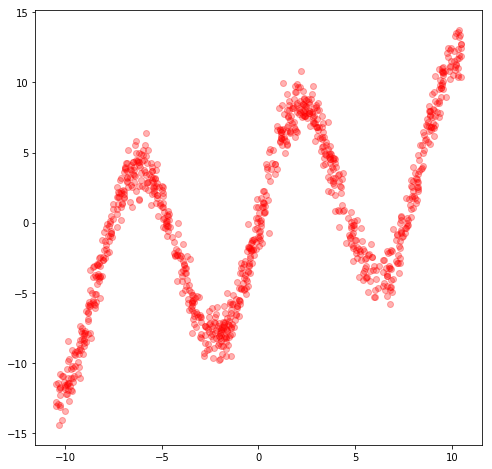

In [3]:
plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

We will define this simple neural network one-hidden layer and 50 nodes:
$Y = W_{out} \tanh( W_{in} X + b_{in}) + b_{out}$

In [4]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# from (https://github.com/jcjohnson/pytorch-examples)
N, D_in, H, D_out = NSAMPLE, 1, 50, 1

In [5]:
# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
# since NSAMPLE is not large, we train entire dataset in one minibatch.
x = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, D_in)))
y = Variable(torch.from_numpy(y_data.reshape(NSAMPLE, D_out)), requires_grad=False)

In [6]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.Tanh(),
          torch.nn.Linear(H, D_out),
        )

We can define a loss function as the sum of square error of the output vs the data (we can add regularisation if we want).

In [7]:
loss_fn = torch.nn.MSELoss()

We will also define a training loop to minimise the loss function later. We can use the RMSProp gradient descent optimisation method.

In [8]:
learning_rate = 0.01
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.8)
for t in range(3000):
  y_pred = model(x)
  loss = loss_fn(y_pred, y)
  if (t % 300 == 0):
    print(t, loss.data[0])

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 38.87970733642578
300 3.7925336360931396
600 1.6691374778747559
900 1.5163427591323853
1200 1.4571599960327148
1500 1.420091986656189
1800 1.3898952007293701
2100 1.3622522354125977
2400 1.3435263633728027
2700 1.3280220031738281


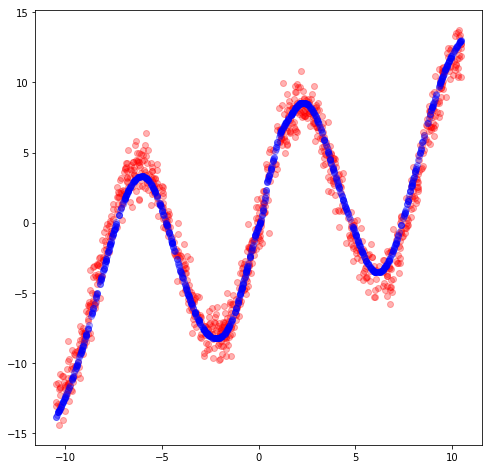

In [9]:
x_test = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
x_test = Variable(torch.from_numpy(x_test.reshape(NSAMPLE, D_in)))
y_test = model(x_test)
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test.data.numpy(),y_test.data.numpy(),'bo',alpha=0.3)
plt.show()

We see that the neural network can fit this sinusoidal data quite well, as expected. However, this type of fitting method only works well when the function we want to approximate with the neural net is a one-to-one, or many-to-one function. Take for example, if we invert the training data:
$x=7.0 \sin( 0.75 y) + 0.5 y+ \epsilon$

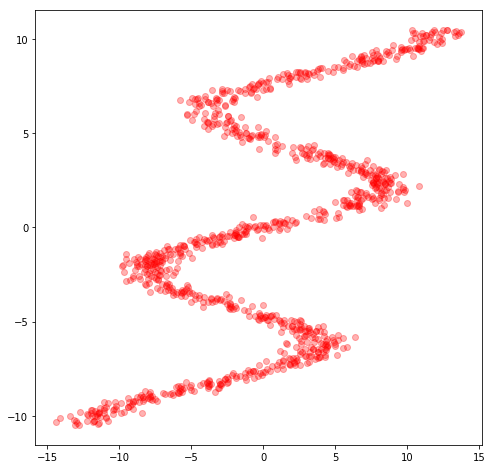

In [10]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

If we were to use the same method to fit this inverted data, obviously it wouldn't work well, and we would expect to see a neural network trained to fit only to the square mean of the data.

In [11]:
x = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, D_in)))
y = Variable(torch.from_numpy(y_data.reshape(NSAMPLE, D_out)), requires_grad=False)
learning_rate = 0.01
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.8)
for t in range(3000):
  y_pred = model(x)
  loss = loss_fn(y_pred, y)
  if (t % 300 == 0):
    print(t, loss.data[0])
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 53.634891510009766
300 20.89899253845215
600 20.859756469726562
900 20.815086364746094
1200 20.763303756713867
1500 20.70337677001953
1800 20.672048568725586
2100 20.612586975097656
2400 20.588672637939453
2700 20.536510467529297


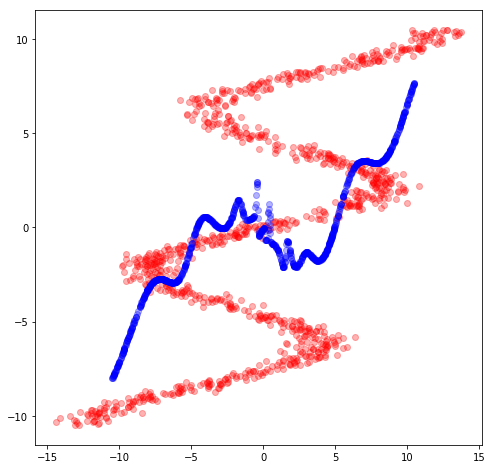

In [12]:
x_test = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
x_test = Variable(torch.from_numpy(x_test.reshape(NSAMPLE, D_in)))
y_test = model(x_test)
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test.data.numpy(),y_test.data.numpy(),'bo',alpha=0.3)
plt.show()

Our current model only predicts one output value for each input, so this approach will fail miserably. What we want is a model that has the capacity to predict a range of different output values for each input. In the next section we implement a Mixture Density Network (MDN) to achieve this task.


## Mixture Density Networks ##


Our current model only predicts one output value for each input, so this approach will fail. What we want is a model that has the capacity to predict a range of different output values for each input. In the next section we implement a *Mixture Density Network (MDN)* to do achieve this task.

Mixture Density Networks, developed by Christopher Bishop in the 1990s, is an attempt to address this problem. Rather to have the network predict a single output value, the MDN predicts an entire *probability distribution* of the output, so we can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate some sort of confidence factor in the predictions that the network is making.

The inverse sinusoidal data we chose is not just for a toy problem, as there are applications in the field of robotics, for example, where we want to determine which angle we need to move the robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture Gaussian distributions, where the output value is modelled as a sum of many gaussian random values, each with different means and standard deviations. So for each input $x$, we will predict a probability distribution function $P(Y = y | X = x)$ that is approximated by a weighted sum of different gaussian distributions.

$P(Y = y | X = x) = \sum_{k=0}^{K-1} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)), \sum_{k=0}^{K-1} \Pi_{k}(x) = 1$

Our network will therefore predict the *parameters* of the pdf, in our case the set of $\mu$, $\sigma$, and $\Pi$ values for each input $x$. Rather than predict $y$ directly, we will need to sample from our distribution to sample $y$. This will allow us to have multiple possible values of $y$ for a given $x$.

Each of the parameters $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ of the distribution will be determined by the neural network, as a function of the input $x$. There is a restriction that the sum of $\Pi_{k}(x)$ add up to one, to ensure that the pdf integrates to 1. In addition, $\sigma_{k}(x)$ must be strictly positive.

In our implementation, we will use a neural network of one hidden later with 50 nodes, and also generate 20 mixtures, hence there will be 60 actual outputs of our neural network of a single input. Our definition will be split into 2 parts:

$Z = W_{out} \tanh( W_{in} X + b_{in}) + b_{out}$

In the first part, $Z$ is a vector of 60 values that will be then splitup into three equal parts, $[Z_{\Pi}, Z_{\sigma}, Z_{\mu}] = Z$, where each of $Z_{\Pi}$, $Z_{\sigma}$, $Z_{\mu}$ are vectors of length 20.

In this PyTorch implementation, unlike the TF version, we will implement this operation with 3 seperate Linear layers, rather than splitting a large $Z$, for clarity:

$Z_{\Pi} = W_{\Pi} \tanh( W_{in} X + b_{in}) + b_{\Pi}$

$Z_{\sigma} = W_{\sigma} \tanh( W_{in} X + b_{in}) + b_{\sigma}$

$Z_{\mu} = W_{\mu} \tanh( W_{in} X + b_{in}) + b_{\mu}$

In the second part, the parameters of the pdf will be defined as below to satisfy the earlier conditions:

$\Pi = \frac{\exp(Z_{\Pi})}{\sum_{i=0}^{20} exp(Z_{\Pi, i})}, \\ \sigma = \exp(Z_{\sigma}), \\ \mu = Z_{\mu}$

$\Pi_{k}$ are put into a *softmax* operator to ensure that the sum adds to one, and that each mixture probability is positive. Each $\sigma_{k}$ will also be positive due to the exponential operator.

Below is the PyTorch implementation of the MDN network:

In [13]:
NHIDDEN = 50 # hidden units
KMIX = 20 # number of mixtures

In [14]:
class MDN(nn.Module):
  def __init__(self, hidden_size, num_mixtures):
    super(MDN, self).__init__()
    self.fc_in = nn.Linear(1, hidden_size) 
    self.tanh = nn.Tanh()
    self.pi_out = torch.nn.Sequential(
          nn.Linear(hidden_size, num_mixtures),
          nn.Softmax()
        )
    self.sigma_out = nn.Linear(hidden_size, num_mixtures)
    self.mu_out = nn.Linear(hidden_size, num_mixtures)  
    
  def forward(self, x):
    out = self.fc_in(x)
    out = self.tanh(out)
    out_pi = self.pi_out(out)
    out_sigma = torch.exp(self.sigma_out(out))
    out_mu = self.mu_out(out)
    return (out_pi, out_sigma, out_mu)

Let's define the inverted data we want to train our MDN to predict later. As this is a more involved prediction task, I used a higher number of samples compared to the simple data fitting task earlier.

In [15]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

In [16]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)))
y_train = Variable(torch.from_numpy(y_data.reshape(NSAMPLE, 1)), requires_grad=False)

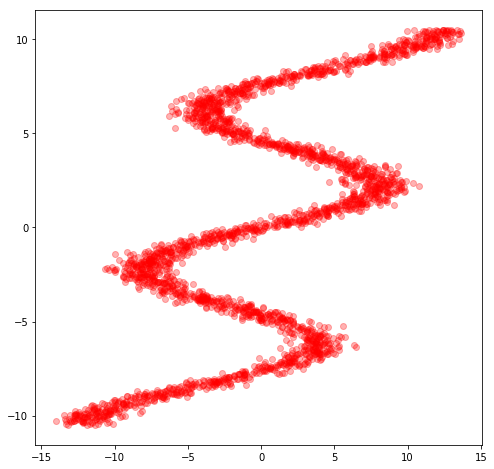

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy(),y_train.data.numpy(),'ro', alpha=0.3)
plt.show()

We cannot simply use the min square error L2 lost function in this task the output is an entire description of the probability distribution. A more suitable loss function is to minimise the logarithm of the likelihood of the distribution vs the training data:

$CostFunction(y | x) = -\log[ \sum_{k}^K \Pi_{k}(x) \phi(y, \mu(x), \sigma(x)) ]$

So for every $(x,y)$ point in the training data set, we can compute a cost function based on the predicted distribution versus the actual points, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:

In [18]:
oneDivSqrtTwoPI = 1.0 / math.sqrt(2.0*math.pi) # normalisation factor for gaussian.
def gaussian_distribution(y, mu, sigma):
  # braodcast subtraction with mean and normalization to sigma
  result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
  result = - 0.5 * (result * result)
  return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [19]:
def mdn_loss_function(out_pi, out_sigma, out_mu, y):
  result = gaussian_distribution(y, out_mu, out_sigma) * out_pi
  result = torch.sum(result, dim=1)
  result = - torch.log(result)
  return torch.mean(result)

Let's define our model, and use the Adam optimizer to train our model below:

In [20]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX)

In [21]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
  (out_pi, out_sigma, out_mu) = model(x_train)
  loss = mdn_loss_function(out_pi, out_sigma, out_mu, y_train)
  if (t % 500 == 0):
    print(t, loss.data[0])
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 7.707841873168945
500 1.6561682224273682
1000 1.4719635248184204
1500 1.4125633239746094
2000 1.3179726600646973
2500 1.279767394065857
3000 1.2737525701522827
3500 1.263033151626587
4000 1.2567297220230103
4500 1.2575756311416626
5000 1.2521675825119019
5500 1.2515537738800049
6000 1.2502440214157104
6500 1.2465747594833374
7000 1.2447233200073242
7500 1.2415266036987305
8000 1.2397814989089966
8500 1.2343288660049438
9000 1.2336210012435913
9500 1.2404125928878784


We want to use our network to generate the parameters of the pdf for us to sample from. In the code below, we will sample $M=10$ values of $y$ for every $x$ input, and compare the sampled results with the training data.

In [22]:
x_test_data = np.float32(np.random.uniform(-15, 15, (1, NSAMPLE))).T
x_test = Variable(torch.from_numpy(x_test_data.reshape(NSAMPLE, 1)))

In [23]:
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

In [24]:
out_pi_test_data = out_pi_test.data.numpy()
out_sigma_test_data = out_sigma_test.data.numpy()
out_mu_test_data = out_mu_test.data.numpy()

In [25]:
def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print('error with sampling ensemble')
  return -1

def generate_ensemble(M = 10):
  # for each point in X, generate M=10 ensembles
  NTEST = x_test_data.size
  result = np.random.rand(NTEST, M) # initially random [0, 1]
  rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NTEST):
      idx = get_pi_idx(result[i, j], out_pi_test_data[i])
      mu = out_mu_test_data[i, idx]
      std = out_sigma_test_data[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

In [26]:
y_test_data = generate_ensemble()

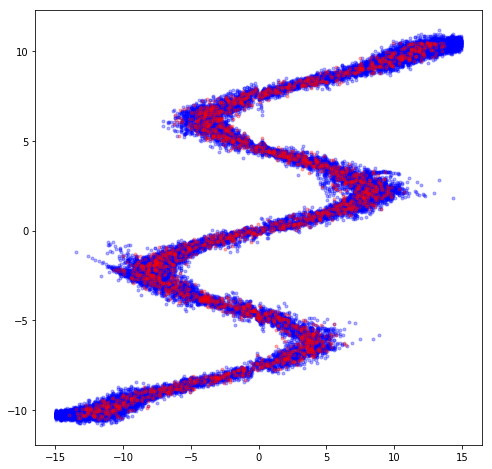

In [46]:
plt.figure(figsize=(8, 8))
plt.plot(x_test_data,y_test_data,'b.', x_data,y_data,'r.',alpha=0.3)
plt.show()

In the above graph, we plot out the generated data we sampled from the MDN distribution, in blue. We also plot the original training data in red over the predictions. Apart from a few outliers, the distributions seem to match the data. We can also plot a graph of $\mu(x)$ as well to interpret what the neural net is actually doing:

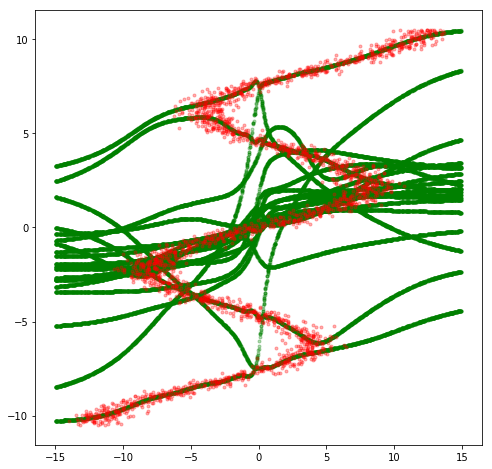

In [47]:
plt.figure(figsize=(8, 8))
plt.plot(x_test_data,out_mu_test_data,'g.', x_data,y_data,'r.',alpha=0.3)
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$ .